In [66]:
import pandas as pd 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import combinations
from statsmodels.tsa.stattools import coint   


In [67]:
close = pd.read_csv('../data/close_prices.csv')
print(close.columns)

Index(['Date', 'AAPL', 'AMZN', 'AVGO', 'GOOGL', 'META', 'MSFT', 'NFLX', 'NVDA',
       'ORCL', 'QQQ', 'SPY', 'TSLA'],
      dtype='object')


In [68]:
# test on lstm outputs first
folder_path = "../LSTM/outputs"

prediction_files = glob.glob(os.path.join(folder_path, "*_predictions.csv"))

dfs = {}
for file in prediction_files:
    name = os.path.basename(file).replace("_predictions.csv", "")
    dfs[name] = pd.read_csv(file)


all_predictions = pd.concat(
    [df.assign(stock=name) for name, df in dfs.items()],
    ignore_index=True
)

In [69]:
predicted = (
    all_predictions
    .pivot(index="Date", columns="stock", values="PredictedPrice")
    .reset_index()
)
display(predicted.head())

stock,Date,AAPL,AMZN,AVGO,GOOGL,META,MSFT,NFLX,NVDA,ORCL,QQQ,SPY,TSLA
0,2023-01-03,114.519516,78.36307,33.496550,63.563602,155.53108,195.68138,304.99542,13.643364,53.049305,165.93988,274.80026,107.360420
1,2023-01-04,113.716484,78.91684,33.637490,63.808025,155.41907,196.17316,305.21637,13.630103,53.495940,165.78568,274.28726,112.083360
2,2023-01-05,113.074950,79.44042,33.770462,63.931328,155.22202,196.40758,307.19970,13.620599,53.997230,165.78750,273.61750,118.941246
3,2023-01-06,112.474890,79.90562,33.872746,64.022820,154.95824,196.31615,310.08636,13.621037,54.468426,165.78844,272.39505,127.969570
4,2023-01-09,112.014720,80.20997,34.276447,64.002650,154.82167,196.01443,313.29813,13.635827,54.990013,166.02893,271.67776,138.273740


# Pairs Selection

In [70]:
close_train = close[close["Date"] < "2023-01-01"].set_index("Date")
log_prices = np.log(close_train)

# correlation
corr_matrix = log_prices.corr()
threshold = 0.8
candidates = [
    (i, j) for i, j in combinations(log_prices.columns, 2)
    if corr_matrix.loc[i, j] > threshold
]

pairs = []
min_len = 200 

for s1, s2 in candidates:
    df_pair = pd.concat(
        [log_prices[s1], log_prices[s2]],
        axis=1,
        keys=[s1, s2]
    ).dropna()

    if len(df_pair) < min_len:
        continue

    # cointegration
    score, pvalue, _ = coint(df_pair[s1], df_pair[s2])
    if pvalue < 0.05:
        x = df_pair[s2].values
        y = df_pair[s1].values

        X = np.column_stack([np.ones(len(x)), x])
        # least squares
        beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]  
        alpha = beta_hat[0]
        beta = beta_hat[1]

        spread = df_pair[s1] - beta * df_pair[s2]

        mu = spread.mean()
        sigma = spread.std()

        pairs.append((s1, s2, pvalue, alpha, beta, mu, sigma))

pairs = sorted(pairs, key=lambda x: x[2])

for p in pairs[:5]:
    s1, s2, pval, alpha, beta, mu, sigma = p
    print(f"{s1} - {s2} | p={pval:.4f} | beta={beta:.4f} | mu={mu:.4f} | sigma={sigma:.4f}")


GOOGL - SPY | p=0.0007 | beta=1.4820 | mu=-4.1332 | sigma=0.0878
ORCL - SPY | p=0.0079 | beta=0.7933 | mu=-0.5182 | sigma=0.0811
GOOGL - ORCL | p=0.0130 | beta=1.7858 | mu=-2.8649 | sigma=0.1762
AAPL - ORCL | p=0.0139 | beta=2.2316 | mu=-4.6513 | sigma=0.2351
GOOGL - QQQ | p=0.0180 | beta=1.0806 | mu=-1.5033 | sigma=0.0958


In [71]:
pair_df = pd.DataFrame(
    pairs,
    columns=["stock1", "stock2", "pvalue", "alpha", "beta", "mu", "sigma"]
)

pair_df = pair_df.sort_values("pvalue").reset_index(drop=True)

# Back test


In [72]:


def backtest_pair(pred_df, pair_row, z_entry=1.0, z_exit=0.5):
    """
    pred_df: DataFrame, columns = ['Date', 'AAPL', 'GOOGL', ...] predicted data after 2023
    pair_row: record from pair_df includes stock1, stock2, beta, mu, sigma
    return: signal, plot
    """
    s1 = pair_row["stock1"]
    s2 = pair_row["stock2"]
    beta = pair_row["beta"]
    mu = pair_row["mu"]
    sigma = pair_row["sigma"]

    df = pred_df.copy().set_index("Date")

    df = df[[s1, s2]].dropna()

    log1 = np.log(df[s1])
    log2 = np.log(df[s2])

    # spread
    spread_pred = log1 - beta * log2

    # z score
    z = (spread_pred - mu) / sigma

    out = pd.DataFrame({
        "Date": df.index,
        "price_" + s1: df[s1],
        "price_" + s2: df[s2],
        "spread": spread_pred,
        "z": z
    }).set_index("Date")

    #   z > z_entry  → short s1, long s2
    #   z < -z_entry → long s1, short s2
    #   |z| < z_exit → flat
    position_s1 = []
    position_s2 = []
    current_pos_s1 = 0.0
    current_pos_s2 = 0.0

    for zi in out["z"]:
        if zi > z_entry:
            # spread is high → short s1, long s2
            current_pos_s1 = -1.0
            current_pos_s2 = +beta
        elif zi < -z_entry:
            # spread is low → vice versa
            current_pos_s1 = +1.0
            current_pos_s2 = -beta
        elif abs(zi) < z_exit:
            current_pos_s1 = 0.0
            current_pos_s2 = 0.0
        position_s1.append(current_pos_s1)
        position_s2.append(current_pos_s2)

    out["pos_" + s1] = position_s1
    out["pos_" + s2] = position_s2

    # log return
    ret1 = np.log(df[s1]).diff()
    ret2 = np.log(df[s2]).diff()

    # strategy log return = pos_s1 * ret1 + pos_s2 * ret2
    strat_ret = out["pos_" + s1] * ret1 + out["pos_" + s2] * ret2
    out["strategy_ret"] = strat_ret.fillna(0.0)
    out["cumret"] = out["strategy_ret"].cumsum()

    return out


In [78]:
def plot_pair_performance(res, pair_row):

    s1, s2 = pair_row["stock1"], pair_row["stock2"]

    res = res.copy()
    if 'Date' in res.columns:
        res['Date'] = pd.to_datetime(res['Date'], errors='coerce')
        res = res.set_index('Date')
    else:
        if not pd.api.types.is_datetime64_any_dtype(res.index):
            try:
                res.index = pd.to_datetime(res.index, errors='raise')
            except Exception:
                if pd.api.types.is_integer_dtype(res.index):
                    res.index = pd.to_datetime(res.index, unit='D', origin='unix')
                else:
                    raise ValueError("Index is not datetime-like and no 'Date' column found.")
    res.index.name = 'Date'

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(res.index, res["cumret"], color="royalblue", linewidth=2, label="Cumulative Return")
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("Cumulative Log Return", fontsize=12, color="royalblue")
    ax1.tick_params(axis='y', labelcolor='royalblue')

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    plt.title(f"Pair Trading Performance: {s1} vs {s2}", fontsize=14, weight='bold')
    plt.grid(alpha=0.3, linestyle="--", linewidth=0.7)
    ax1.legend(loc="upper left")

    plt.tight_layout()
    plt.show()



In [74]:

def compute_pair_metrics(res):

    daily_ret = res["strategy_ret"].dropna()
    n_days = len(daily_ret)

    if n_days == 0:
        return {
            "CumulativeReturn": np.nan,
            "AnnualizedReturn": np.nan,
            "AnnualVolatility": np.nan,
            "SharpeRatio": np.nan,
            "MaxDrawdown": np.nan,
            "WinRate": np.nan,
            "Days": 0,
        }

    final_cumlog = res["cumret"].iloc[-1]

    total_return = np.exp(final_cumlog) - 1

    ann_return = (1 + total_return) ** (252 / n_days) - 1

    daily_std = daily_ret.std()
    ann_vol = daily_std * np.sqrt(252)


    if daily_std == 0:
        sharpe = np.nan
    else:
        sharpe = daily_ret.mean() / daily_std * np.sqrt(252)

    equity = np.exp(res["cumret"])            
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()

   
    win_rate = (daily_ret > 0).mean()

    return {
        "CumulativeReturn": total_return,   
        "AnnualizedReturn": ann_return,
        "AnnualVolatility": ann_vol,
        "SharpeRatio": sharpe,
        "MaxDrawdown": max_dd,
        "WinRate": win_rate,
        "Days": n_days,
    }



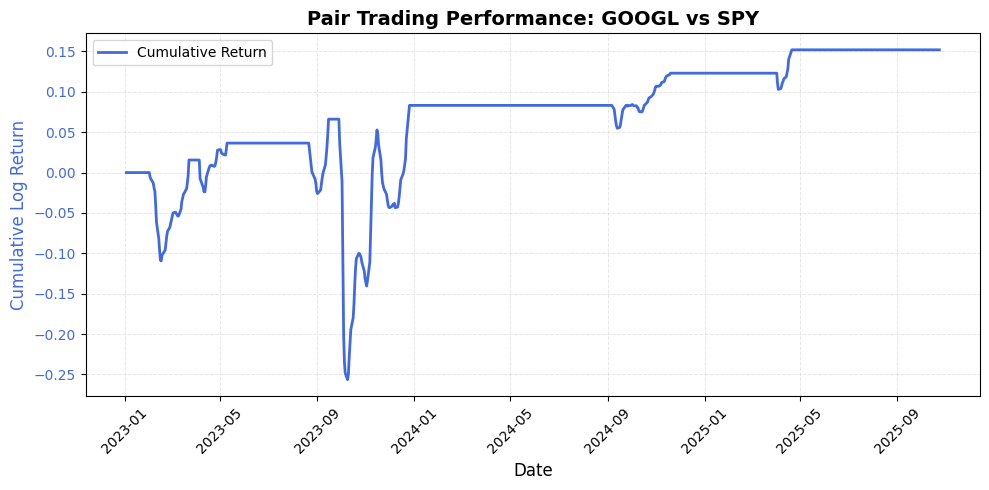

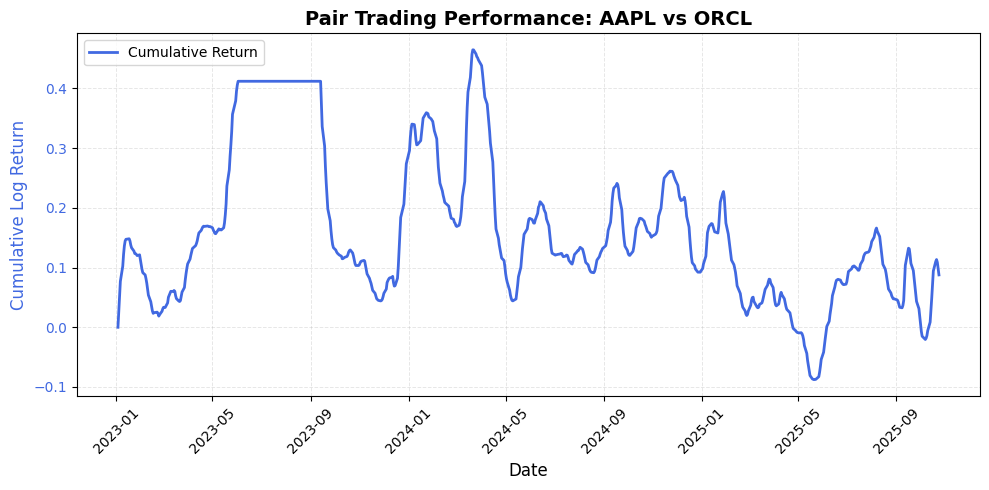

,CumulativeReturn,AnnualizedReturn,AnnualVolatility,SharpeRatio,MaxDrawdown,WinRate,Days
Pair,,,,,,,
GOOGL-SPY,0.1642,0.0558,0.1222,0.4442,-0.2758,0.1756,706
AAPL-ORCL,0.0917,0.0318,0.1622,0.1930,-0.4245,0.4221,706


In [79]:

pairs_to_use = [
    ("GOOGL", "SPY"),
    ("AAPL", "ORCL"),
]


results = {}
for s1, s2 in pairs_to_use:
    match = pair_df[(pair_df["stock1"] == s1) & (pair_df["stock2"] == s2)]
    if match.empty:
        print(f"⚠️ Pair ({s1}, {s2}) not found in pair_df, skipped.")
        continue

    row = match.iloc[0]
    key = (s1, s2)
    results[key] = backtest_pair(predicted, row)

    # plot
    plot_pair_performance(results[key], row)
    
metrics_summary = []
for (s1, s2), res in results.items():
    m = compute_pair_metrics(res)
    m["Pair"] = f"{s1}-{s2}"
    metrics_summary.append(m)

df_metrics = pd.DataFrame(metrics_summary).set_index("Pair")
display(df_metrics.round(4))



In [76]:
test = results[('GOOGL',
  'SPY')]
test[test['strategy_ret'] > 0]

,price_GOOGL,price_SPY,spread,z,pos_GOOGL,pos_SPY,strategy_ret,cumret
Date,,,,,,,,
2023-02-17,71.674070,329.50050,-4.320020,-2.128319,1.0,-1.482024,0.007043,-0.102461
2023-02-21,72.335526,330.10013,-4.313529,-2.054350,1.0,-1.482024,0.006492,-0.095969
2023-02-22,72.746070,329.30790,-4.304308,-1.949288,1.0,-1.482024,0.009221,-0.086749
2023-02-23,72.987060,328.18580,-4.295942,-1.853965,1.0,-1.482024,0.008366,-0.078383
2023-02-24,73.051400,327.11447,-4.290215,-1.788711,1.0,-1.482024,0.005727,-0.072656
...,...,...,...,...,...,...,...,...
2025-04-14,77.805990,325.90524,-4.221672,-1.007705,1.0,-1.482024,0.002433,0.118624
2025-04-15,78.519170,326.92245,-4.217166,-0.956364,1.0,-1.482024,0.004506,0.123130
2025-04-16,79.228630,327.78198,-4.212062,-0.898212,1.0,-1.482024,0.005104,0.128233
